# Preaparation

### Load train pics

In [1]:
path_to_lfpw = 'C:\\_personal\\menpo\\lfpw\\'

import menpo.io as mio

training_images = []
# load landmarked images
for i in mio.import_images(path_to_lfpw + 'trainset/*', verbose=True):
    # crop image
    i.crop_to_landmarks_proportion(0.1)
    # convert it to greyscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    training_images.append(i)

Importing assets: [==========] 100% (811/811) - done.                           


:0: FutureWarning: IPython widgets are experimental and may change in the future.


### Train SDM

In [2]:
from menpofit.sdm import SDMTrainer

fitter = SDMTrainer(normalization_diagonal=150,
                    downscale=1.1,
                    n_perturbations=15).train(training_images, verbose=True)

- Normalizing images size: Done
- Computing top-level feature space: 100% - done.                               
- Apply pyramid: Done
- Building regressors for each of the 3 pyramid levels
                         
Level 1:
- Regression RMSE is 21.58306.
- Fitting shapes: mean error is 0.029891.
                                      
Level 2:
- Regression RMSE is 14.07839.
- Fitting shapes: mean error is 0.017710.
                                      
Level 3:
- Regression RMSE is 13.05907.
- Fitting shapes: mean error is 0.014436.


C:\Anaconda\lib\site-packages\menpo\image\base.py:1632: MenpoDeprecationWarning: rescale_to_reference_shape() is deprecated and will be removed in the next major version of menpo. Please use rescale_to_pointcloud() instead.
  MenpoDeprecationWarning)


### Load face detector

In [3]:
from menpodetect.opencv import load_opencv_frontal_face_detector

face_detector = load_opencv_frontal_face_detector()

# Action

### Load images

In [15]:
from os import walk
from os.path import join

from menpo.io import import_image


base_path = 'C:\\_personal\\menpo\\images\\set2'

files = []
for (dirpath, dirnames, filenames) in walk(base_path):
    files.extend(filenames)
    break

test_images = []
for each in files:
    file_path = join(base_path, each)
    print file_path
    test_images.append(import_image(join(base_path, file_path)))

C:\_personal\menpo\images\set2\713311196_38512_8817511061663432532.jpg
C:\_personal\menpo\images\set2\713312878_38747_2527464462848622590.jpg
C:\_personal\menpo\images\set2\photo3792009902008799.jpg
C:\_personal\menpo\images\set2\photo3792009902008800.jpg
C:\_personal\menpo\images\set2\photo3792009902008801.jpg
C:\_personal\menpo\images\set2\photo3792009902008802.jpg
C:\_personal\menpo\images\set2\photo3792009902008803.jpg
C:\_personal\menpo\images\set2\photo3792009902008804.jpg
C:\_personal\menpo\images\set2\photo3792009902008805.jpg
C:\_personal\menpo\images\set2\photo3792009902008806.jpg
C:\_personal\menpo\images\set2\photo3792009902008807.jpg
C:\_personal\menpo\images\set2\photo3792009902008808.jpg
C:\_personal\menpo\images\set2\photo3792009902008809.jpg
C:\_personal\menpo\images\set2\photo3792009902008810.jpg
C:\_personal\menpo\images\set2\photo3792009902008811.jpg


In [16]:
%matplotlib inline

### Detect faces

In [17]:
face_found = []
face_not_found = []
for pic in test_images:
    face_detector(pic)
    if pic.n_landmark_groups > 0:
        face_found.append(pic)
    else:
        face_not_found.append(pic)

print 'Found:', len(face_found)
print 'Not found:', len(face_not_found)

Found: 7
Not found: 8


### Set initial landmarks (some magic)

In [67]:
prepare = []
for each_pic in face_found:
    for landmarks_group in each_pic.landmarks.group_labels:
        pic = each_pic.copy()
        pic = pic.crop_to_landmarks_proportion(0.1, group=landmarks_group)
        if pic.n_channels > 1:
            pic = pic.as_greyscale(mode='luminosity')
        pic.landmarks['face_box'] = pic.landmarks[landmarks_group]
        prepare.append(pic)

face_sq = [pic.landmarks['face_box'].lms for pic in prepare]

ref_shape = fitter.reference_shape

In [68]:
from menpo.transform import Translation, NonUniformScale


for i, pic in enumerate(prepare):
    x = face_sq[i].points[1][0] - face_sq[i].points[0][0]
    y = face_sq[i].points[2][1] - face_sq[i].points[0][1]
    shape_x = ref_shape.bounding_box().points[1][0] - ref_shape.bounding_box().points[0][0]
    shape_y = ref_shape.bounding_box().points[2][1] - ref_shape.bounding_box().points[0][1]
    rescale = NonUniformScale([0.8 * x / shape_x, 0.7 * y / shape_y]).apply(ref_shape)
    move = Translation(face_sq[i].points[0] - rescale.bounding_box().points[0] + [x / 4.0, y / 8.0]).apply(rescale)
    pic.landmarks['a1'] = move

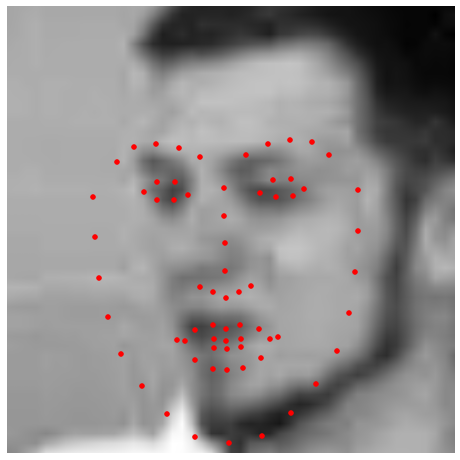

In [70]:
from menpo.visualize import visualize_images

visualize_images(prepare)

### Run fitter

In [71]:
fr = [fitter.fit(pic, pic.landmarks['a1'].lms) for pic in prepare]

### Label results

In [72]:
res = [pic.fitted_image for pic in fr]

In [73]:
from menpo.landmark.labels import labeller, ibug_face_68

for pic in res:
    labeller(pic, 'final', ibug_face_68)

### View result

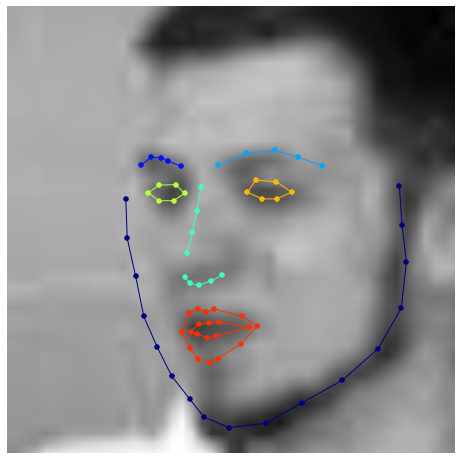

In [74]:
from menpo.visualize import visualize_images

visualize_images(res)

### Save all images with landmarks!

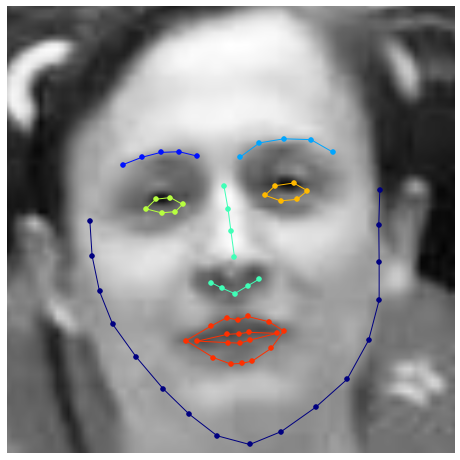

In [110]:
import matplotlib.pyplot as plt

for i, item in enumerate(res):
    plt.clf()
    c = item.view_landmarks(group='ibug_face_68')
    c.save_figure('%d.png' % i, overwrite=True)